In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import warnings
warnings.filterwarnings('ignore')

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

## Reflect Tables into SQLalchemy ORM

In [6]:
Base = automap_base()
#reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
Base.classes.keys()

['measurement', 'station']

In [8]:
 # Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Exploratory Climate Analysis

In [10]:
from sqlalchemy import inspect
inspect = inspect(engine)

c = session.execute('''SELECT * FROM Measurement''')
#for row in c:
 #   print(row)
    
d = session.execute('''SELECT * FROM Station''')
#for i in d:
 #   print(i)


columns = inspect.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspect.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


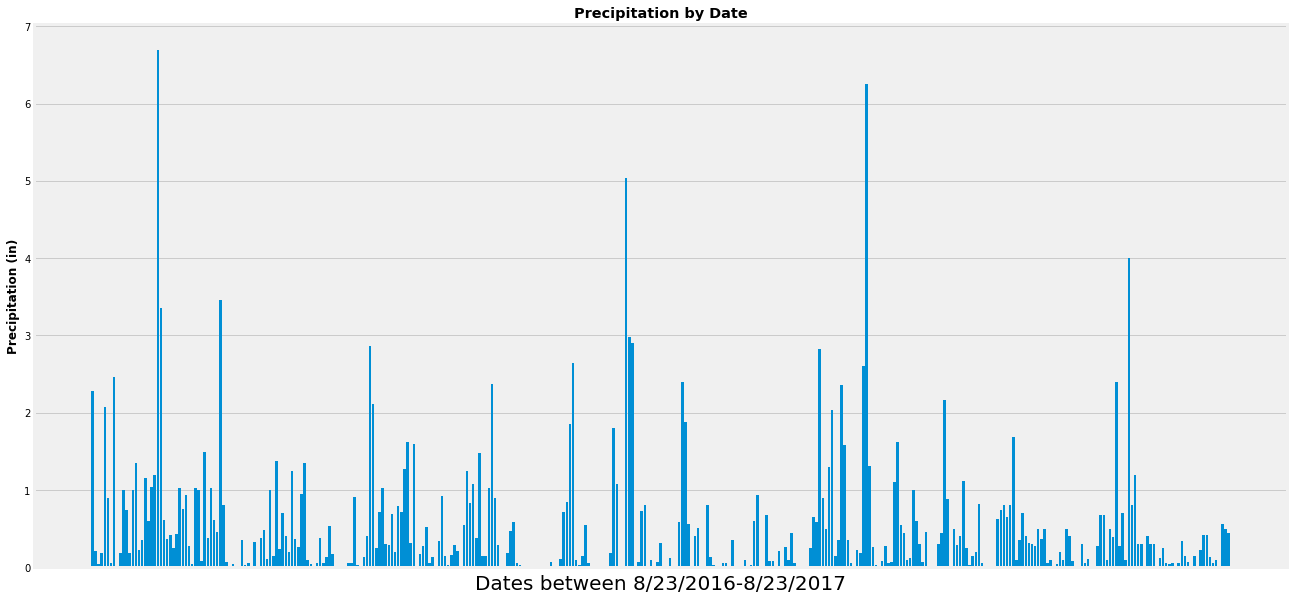

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
from dateutil.relativedelta import relativedelta

date = session.query(Measurement.date).order_by(Measurement.date.desc())[0]
last_date = dt.datetime.strptime(date[0], '%Y-%m-%d')

year_before = last_date - relativedelta(years=1)

filters = (Measurement.date >= year_before)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).filter(filters).order_by(Measurement.date)

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(precip, columns=["Date", "Precipitation"])

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(20,10))
plt.bar(rain_df["Date"], rain_df["Precipitation"], align='center')

plt.xlabel('Dates between 8/23/2016-8/23/2017', fontsize=20)
plt.ylabel('Precipitation (in)', fontweight="bold")
plt.title('Precipitation by Date', fontweight="bold")

plt.grid(axis='x')
plt.xticks("", rotation=90, fontweight="bold")

plt.savefig('Graphs/Precipation by Date.png')

plt.show()

In [13]:
#Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = rain_df.describe()
summary_stats

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
#Design a query to show how many stations are available in this dataset?
stations = session.query(Station.id).count()

print(f"There are {stations} stations available.")

There are 9 stations available.


In [15]:
#What are the most active stations? (What stations have the most rows?)
#List the stations and the counts in descending order
active_stations = session.query(Station.station, func.count(Station.id)).\
filter(Station.station == Measurement.station).\
group_by(Measurement.station).\
order_by(func.count(Station.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
#Using the station id from the previous query, calculate the lowest termperature recorded, highest, and average of active stations.
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).all()

[('USC00519397', 53.0, 87.0, 73.09795396419437)]

In [17]:
#Choose the station with the highest number of temperature observations.
#Query the last 12 months of temperature observation data for this staion and plot the results as a histogram

high_station = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == active_stations[0][0]).\
filter(filters).all()
high_station_df = pd.DataFrame(high_station, columns=["Date", "Temp"]).sort_values(by='Date',ascending=True)
station_df = high_station_df.set_index('Date')
station_df

,Temp
Date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


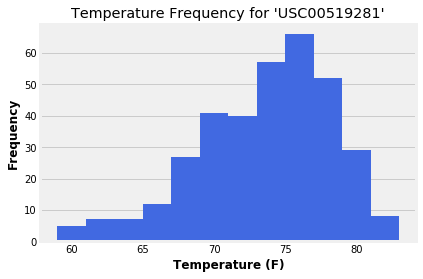

In [18]:
#Plot as a histogram

plt.hist(station_df["Temp"], bins=12, color='royalblue')
plt.grid(axis='x')
plt.xlabel('Temperature (F)', fontweight="bold")
plt.ylabel("Frequency", fontweight="bold")
plt.title("Temperature Frequency for 'USC00519281'")

plt.savefig("Graphs/Histogram_Temperature Frequency.png")
plt.show()

## Climate App

In [ ]:
# This function is called 'calc_temps' will accept start date and end date in the format '%Y-%m-%d'
#and return the minimum, average, and maximum temperatures for that range of dates
def calc_emps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates"""